# SMART LIVE CAMERA NOTEBOOK

## Necessary modules

In [1]:
# Import Modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
import tarfile
import seaborn
import random
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import display, Image
from scipy import ndimage
from scipy.io import loadmat
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## Generic functions

### Data Preprocessing Functions

In [2]:
last_percent_reported = None
num_classes = 10

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(URL + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

def maybe_extract(filename, force=False):
  """Extract a file (tar). If force=True, override the current files and folders"""
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

### Eval Functions

In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == labels)
          / predictions.shape[0])

## 2. STEP TWO: SINGLE DIGIT SVHN DATA

### Downloading data

In [3]:
URL = 'http://ufldl.stanford.edu/housenumbers/'
TRAIN_FILENAME= 'train_32x32.mat'
TEST_FILENAME = 'test_32x32.mat'
EXTRA_FILENAME = 'extra_32x32.mat'

train_filename = maybe_download(TRAIN_FILENAME, 182040794)
test_filename = maybe_download(TEST_FILENAME, 64275384)
# extra_filename = maybe_download(EXTRA_FILENAME, 100) 

Found and verified train_32x32.mat
Found and verified test_32x32.mat


### Extracting data

In [5]:
IMAGE_SIZE = 32
PIXEL_DEPTH = 255
NUM_CHANNELS = 3
VALIDATION_SIZE = 8000

def extract_data(filename):
  """Extract the images into a 3D tensor [image index, y, x].
  Using scipy.io.loadmat 
  """
  print('Extracting', filename)
  data_matfile = loadmat(filename)
  data = data_matfile['X']
  data = data.transpose(3,0,1,2).astype(np.float32)
  labels = data_matfile['y']
  labels[labels == 10] = 0
  labels = labels.reshape(labels.shape[0],).astype(np.float32)
  return data, labels

train_dataset, train_labels = extract_data('train_32x32.mat')
test_dataset, test_labels = extract_data('test_32x32.mat')
valid_dataset = test_dataset[:VALIDATION_SIZE, ...]
valid_labels = test_labels[:VALIDATION_SIZE]
test_dataset = test_dataset[VALIDATION_SIZE:, ...]
test_labels = test_labels[VALIDATION_SIZE:]
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Extracting train_32x32.mat
Extracting test_32x32.mat
Training set (73257, 32, 32, 3) (73257,)
Validation set (8000, 32, 32, 3) (8000,)
Test set (18032, 32, 32, 3) (18032,)


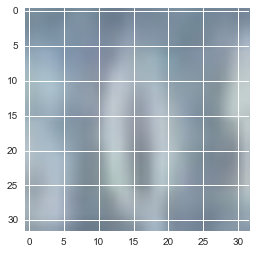

0.0


In [6]:
#rd = random.randint(0, len(train_dataset))
rd = 52
plt.imshow(train_dataset[rd,:,:,:])
plt.show()

print(train_labels[rd])

### CNN LeNet-5-like convolutional

#### Image Processing

In [7]:
INITIAL_IMAGE_SIZE = 32
INITIAL_NUM_CHANNELS = 3
IMAGE_SIZE = 32
NUM_CHANNELS = 1
NUM_LABELS = 10

def images_processing(images):
  # Color to Grayscale, is this necessary? At least it's more efficient, and this is really important at this moment.
  # It could be processed with 3 channels image (for that reason we use conv networks)
  grayscale = tf.image.rgb_to_grayscale(images, name=None)
  gcn = tf.map_fn(tf.image.per_image_whitening, grayscale) # Global Contrast Normalization
  return gcn

In [8]:
tf_train_dataset = tf.Variable(train_dataset)
tf_test_dataset = tf.Variable(test_dataset)
tf_valid_dataset = tf.Variable(valid_dataset)

tfp_train_dataset = images_processing(tf_train_dataset)
tfp_test_dataset = images_processing(tf_test_dataset)
tfp_valid_dataset = images_processing(tf_valid_dataset)

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
train_dataset, test_dataset, valid_dataset = sess.run([tfp_train_dataset, tfp_test_dataset, tfp_valid_dataset])
  
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)  

Training set (73257, 32, 32, 1) (73257,)
Validation set (8000, 32, 32, 1) (8000,)
Test set (18032, 32, 32, 1) (18032,)


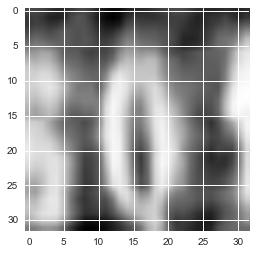

0.0
Training set (73257, 32, 32, 1) (73257,)
Validation set (8000, 32, 32, 1) (8000,)
Test set (18032, 32, 32, 1) (18032,)


In [9]:
#rd = random.randint(0, len(train_dataset))
rd = 52
sample = train_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(train_labels[rd])
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)  

In [12]:
# TODO -> DATA TO PICKLE?

In [11]:
BATCH_SIZE = 64
PATCH_SIZE_1 = 5
PATCH_SIZE_2 = 7
DEPTH_1 = 32
DEPTH_2 = 64
HIDDEN_NODES = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # 5x5 Filter, depth 16 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE_1, PATCH_SIZE_1, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 7x7 Filter, depth 128
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE_2, PATCH_SIZE_2, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))

  # Fully connected depth 256
  fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * DEPTH_2, HIDDEN_NODES],
                                                   stddev=0.1))
  fc1_biases = tf.Variable(tf.constant(1.0, shape=[HIDDEN_NODES]))
  
  fc2_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  fc2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
  # Model.
  def model(data):
    
    # 2D Conv Layer
    conv = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
    # Max pooling. The kernel size spec {ksize} also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # Normalize 
    lrn = tf.nn.local_response_normalization(pool)

    # 2D Conv + ReLU + MaxPooling
    conv = tf.nn.conv2d(lrn, conv2_weights, [1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    lrn = tf.nn.local_response_normalization(relu)
    pool = tf.nn.max_pool(lrn, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
        
    # Fully connected  
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    return tf.matmul(hidden, fc2_weights) + fc2_biases  
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
  
NUM_STEPS = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(NUM_STEPS):
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    batch_data = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.591652
Minibatch accuracy: 15.6%
Validation accuracy: 9.9%
Minibatch loss at step 500: 1.915544
Minibatch accuracy: 34.4%
Validation accuracy: 36.9%
Minibatch loss at step 1000: 1.134560
Minibatch accuracy: 70.3%
Validation accuracy: 62.5%
Minibatch loss at step 1500: 0.873245
Minibatch accuracy: 71.9%
Validation accuracy: 74.6%


KeyboardInterrupt: 